# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


<span style='color:Blue'> 
    Collaborators: Hanyi Wang, Cecilia Liu, Yumin Wang, Mark Kim
</span>

In [555]:
# useful libraries to import

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import manifold

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

import textwrap

from statsmodels.graphics.tsaplots import plot_acf

In [44]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('./data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')

/var/folders/gh/wjs3pzl11758g8crdf96rf8c0000gn/T/ipykernel_22549/1708817607.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('./data/ENCODE_GRCh38_bigWig_metadata.tsv')


- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


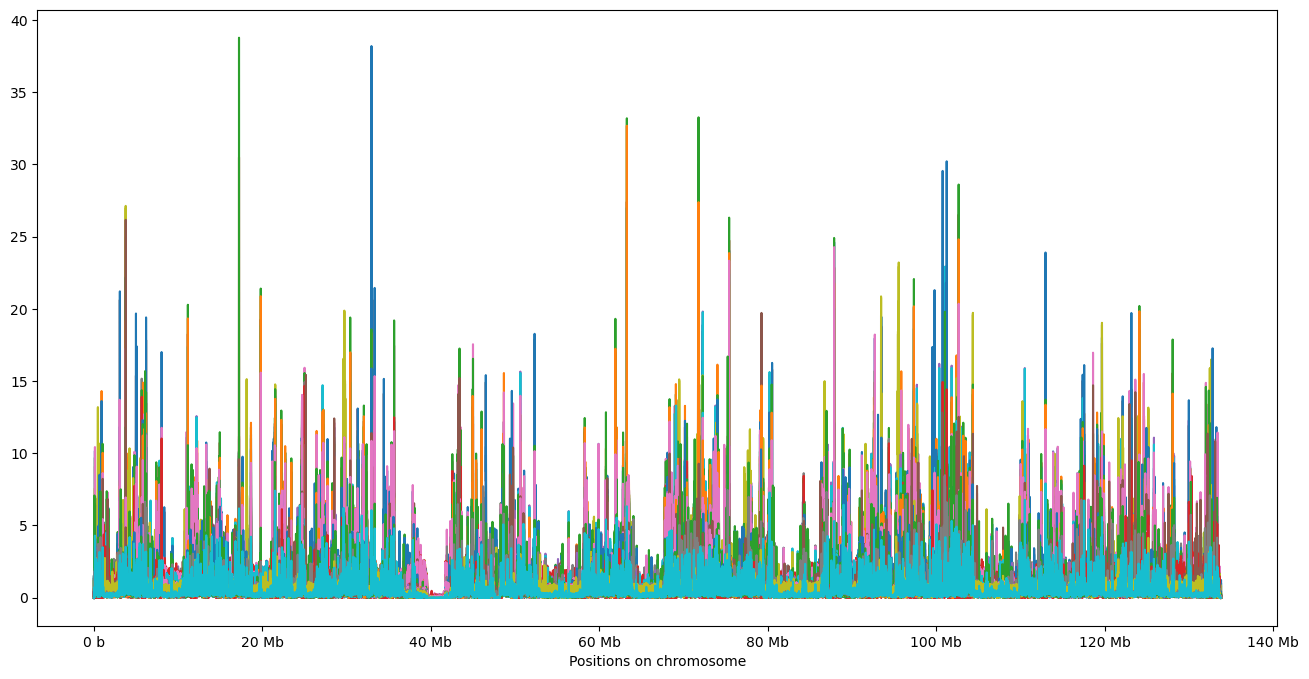

In [128]:
profiles = df.columns[3:]

fig, ax = plt.subplots(figsize = (16, 8))
for i in range(profiles.shape[0]):
    profile = profiles[i]
    ax.plot(df['start'], df[profile])
    ax.xaxis.set_major_formatter(bp_formatter)
ax.set(xlabel='Positions on chromosome')
    
plt.show()


<span style='color:Blue'> 
    Many signals dip on chr10 at around 40Mb, because the centromere on chr10 is around 40Mb.
</span>

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


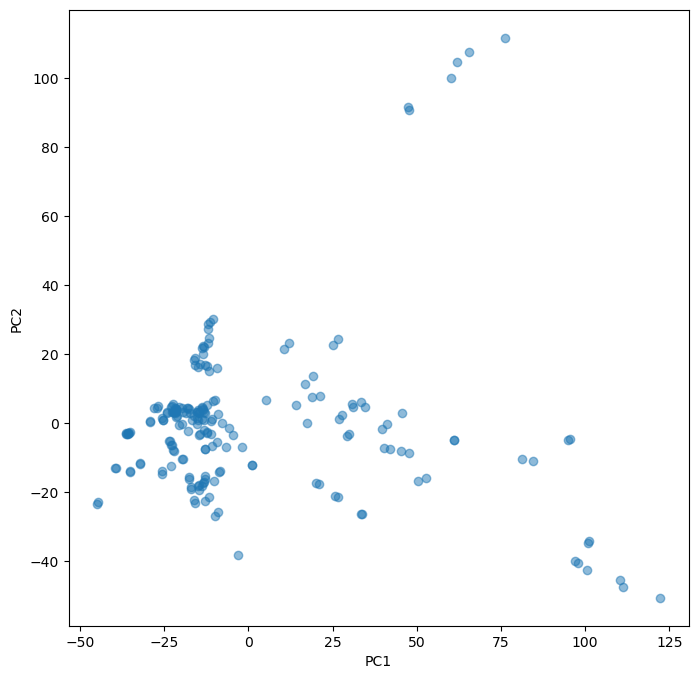

In [133]:
df_signals = df.iloc[:, 3:]
df_signals_t = df_signals.T
pca = PCA(n_components = 2)
df_signals_t_pca = pca.fit_transform(df_signals_t)

fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(df_signals_t_pca[:, 0], df_signals_t_pca[:, 1], alpha = 0.5)
ax.set(xlabel = "PC1", ylabel = "PC2")
plt.show()

- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

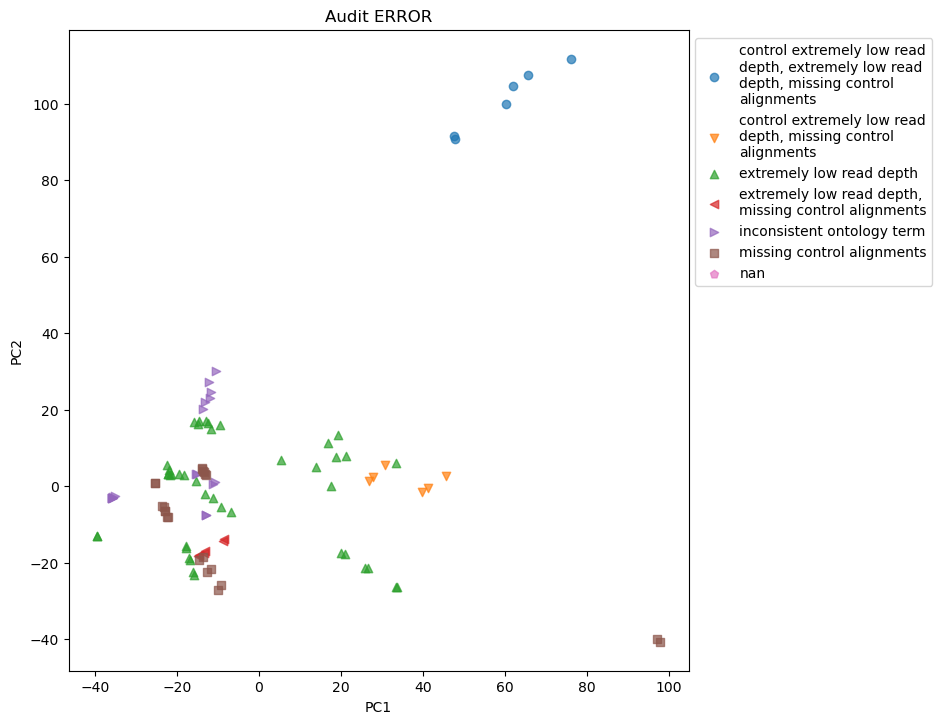

In [352]:
def find_labels(col):
    labels = []
    for profile in profiles:
        labels.append(bigwig_metadata[bigwig_metadata["File accession"] == profile][col].values[0])
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(labels)
    return le, labels

cols = bigwig_metadata.columns
le, labels = find_labels(cols[58])

wrapper = textwrap.TextWrapper(width = 30)
new_labels = []
for label in list(le.classes_):
    new_labels.append(wrapper.fill(label))

markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', 
           '1', '2', '3', '4', 'x']

data = {'PC1': df_signals_t_pca[:, 0], 'PC2': df_signals_t_pca[:, 1], "label": labels}
df_label = pd.DataFrame(data = data)

fig, ax = plt.subplots(figsize = (8, 8.325))

for i, l in enumerate(le.classes_):
    X = df_label[df_label.label == l].iloc[:,0]
    Y = df_label[df_label.label == l].iloc[:,1]
    ax.scatter(X, Y, alpha = 0.7, label = l, marker = markers[i % len(markers)])
    # overlay labels when there are so many categories that points cannot be distinguished simply by colors
    # for j in range(X.size):
    #     plt.text(X.iloc[j], Y.iloc[j], l)
    
ax.legend(new_labels, loc = (1.01, 0.6))
ax.set(xlabel = "PC1", ylabel = "PC2", title = cols[58])
plt.show()

<span style='color:Blue'> 
    Column "Audit ERROR" seems to be useful for outlier removal. The points with PC2 > 0.2 (shown above in blue circles) are probably outliers, as they are far away from most of the other points. Additionally, according to the information in the column "Audit ERROR", these points have "control extremely low read depth, extremely low read depth, missing control alignments," which represents the most severe errors of all the categories in the column.
</span>

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


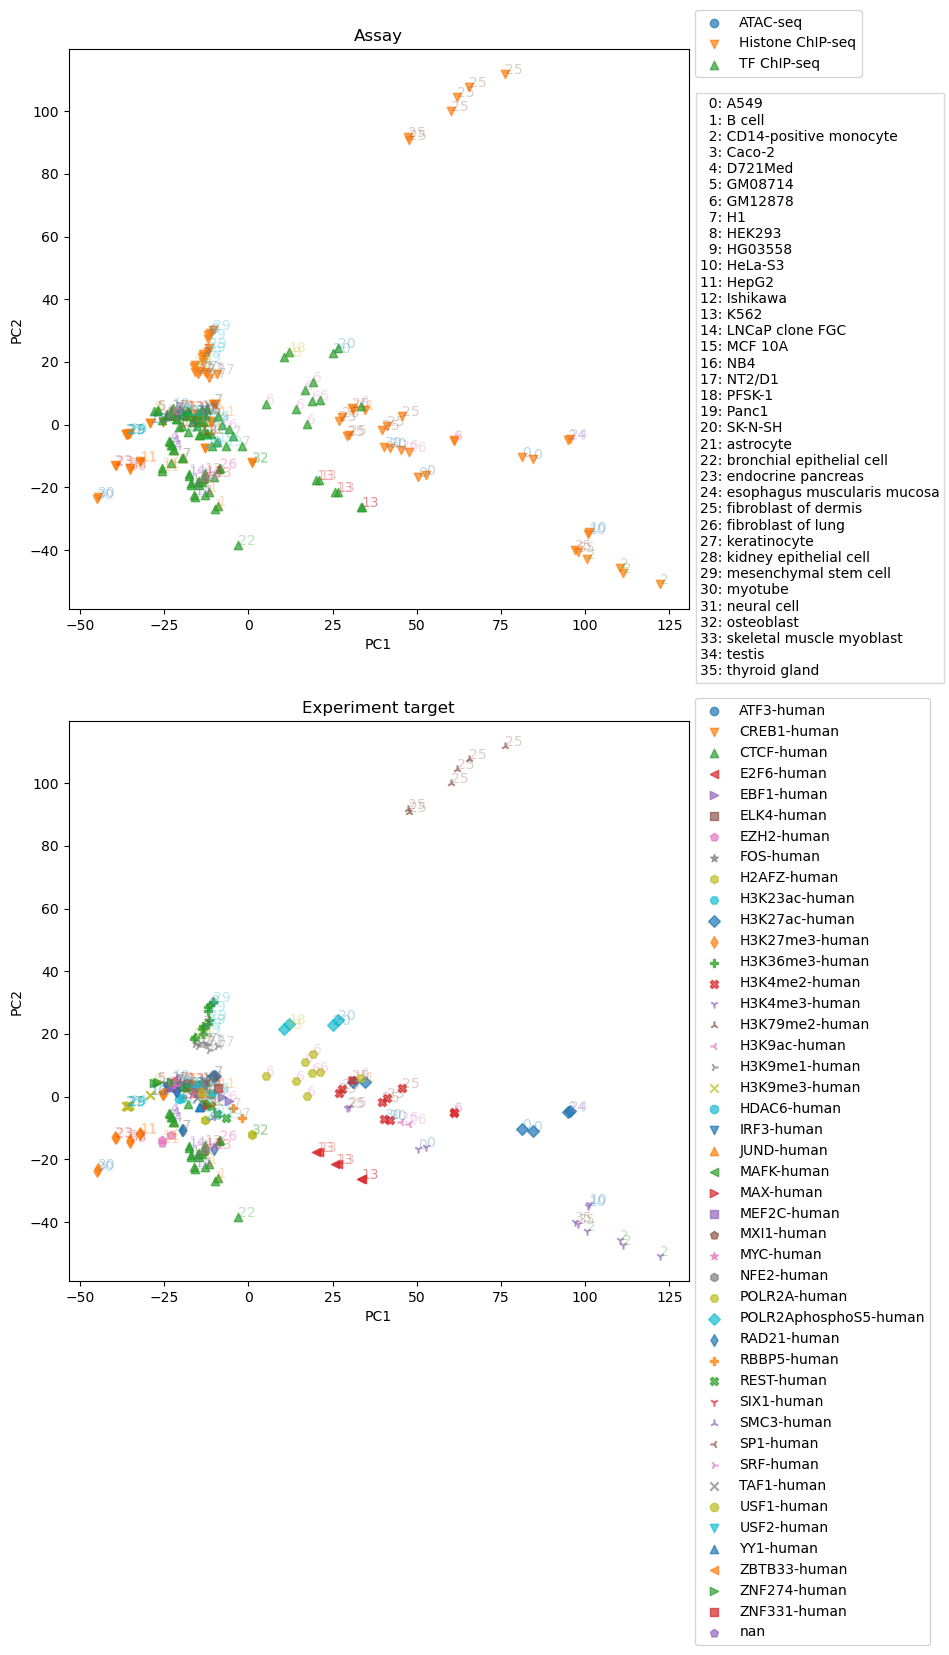

In [656]:
le_assay, labels_assay = find_labels("Assay")
le_expt_tar, labels_expt_tar = find_labels("Experiment target")
le_term, labels_term = find_labels("Biosample term name")

term_index = le_term.transform(labels_term)
term_color = list(map(lambda x: colors[x % len(colors)], term_index))

data = {'PC1': df_signals_t_pca[:, 0], 'PC2': df_signals_t_pca[:, 1], 
        "assay": labels_assay, "expt_tar": labels_expt_tar, "term": labels_term, 
        "term_index": term_index, "term_color": term_color}
df_label = pd.DataFrame(data = data)

df_label["assay_index"] = le_assay.transform(labels_assay)
df_label["expt_tar_index"] = le_expt_tar.transform(labels_expt_tar)



palette = mcolors.TABLEAU_COLORS
palette_list = list(palette)
colors = []
for color in palette:
    colors.append(palette[color])

fig, axs = plt.subplots(2, figsize = (8, 16))


for i, la in enumerate(le_assay.classes_):
    X = df_label[df_label.assay == la].iloc[:,0]
    Y = df_label[df_label.assay == la].iloc[:,1]
    axs[0].scatter(X, Y, alpha = 0.7, label = la,
                   marker = markers[i % len(markers)], c = colors[i % len(colors)])

for i in range(df_label.shape[0]):
    axs[0].text(df_label.iloc[i, 0], df_label.iloc[i, 1], df_label.iloc[i, 5], 
                c = df_label.iloc[i, 6], alpha = 0.3)

    
axs[0].set(xlabel = "PC1", ylabel = "PC2", title = "Assay")
axs[0].legend(loc = (1.01, 0.95))


text = ""
for i, term in enumerate(le_term.classes_):
    if i < 10:
        text = text + "  "
    text = text + str(i) + ": " + term
    if i != le_term.classes_.size - 1:
        text = text + "\n"
axs[0].text(134, -80, text, bbox = dict(boxstyle = "square", ec = (0.85, 0.85, 0.85), fc = (1, 1, 1)))



for i, lex in enumerate(le_expt_tar.classes_):
        X = df_label[df_label.expt_tar == lex].iloc[:,0]
        Y = df_label[df_label.expt_tar == lex].iloc[:,1]
        axs[1].scatter(X, Y, alpha = 0.7, label = lex, 
                       marker = markers[i % len(markers)], c = colors[i % len(colors)])

for i in range(df_label.shape[0]):
    axs[1].text(df_label.iloc[i, 0], df_label.iloc[i, 1], df_label.iloc[i, 5], 
                c = df_label.iloc[i, 6], alpha = 0.3)
    
axs[1].legend(loc = (1.01, -0.65))
axs[1].set(xlabel = "PC1", ylabel = "PC2", title = "Experiment target")

plt.show()


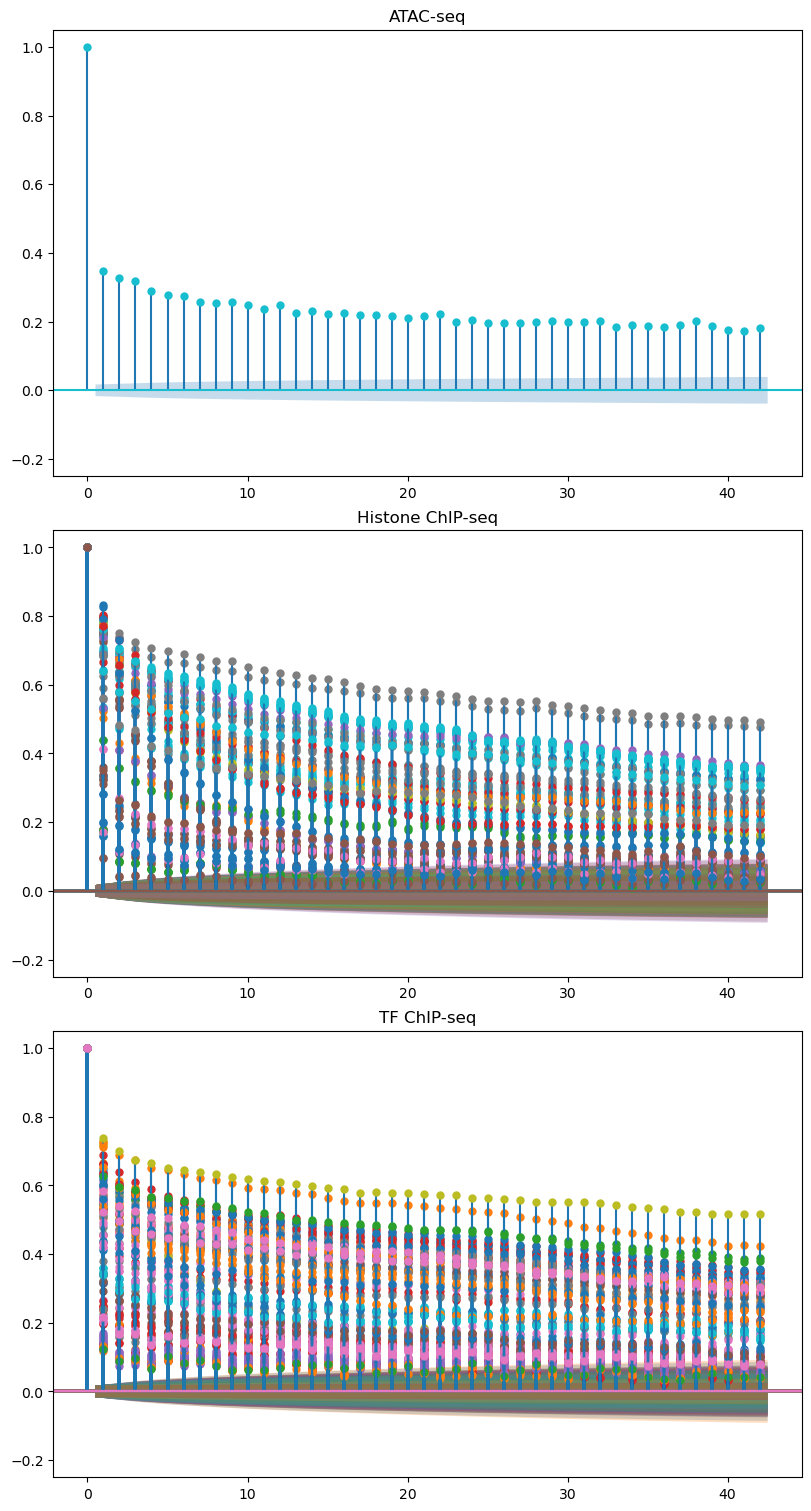

In [661]:
fig, axs = plt.subplots(3, figsize = (8, 15), constrained_layout=True)
for i in range(200):
    data_i = df_signals.iloc[:, i]
    row_i = df_label.iloc[i, 7]
    color_i = df_label.iloc[i, 6]
    plot_acf(data_i, ax = axs[row_i], c = color_i)
for i in range(3):
    axs[i].set(title = list(le_assay.classes_)[i], ybound = (-0.25, 1.05))
plt.show()

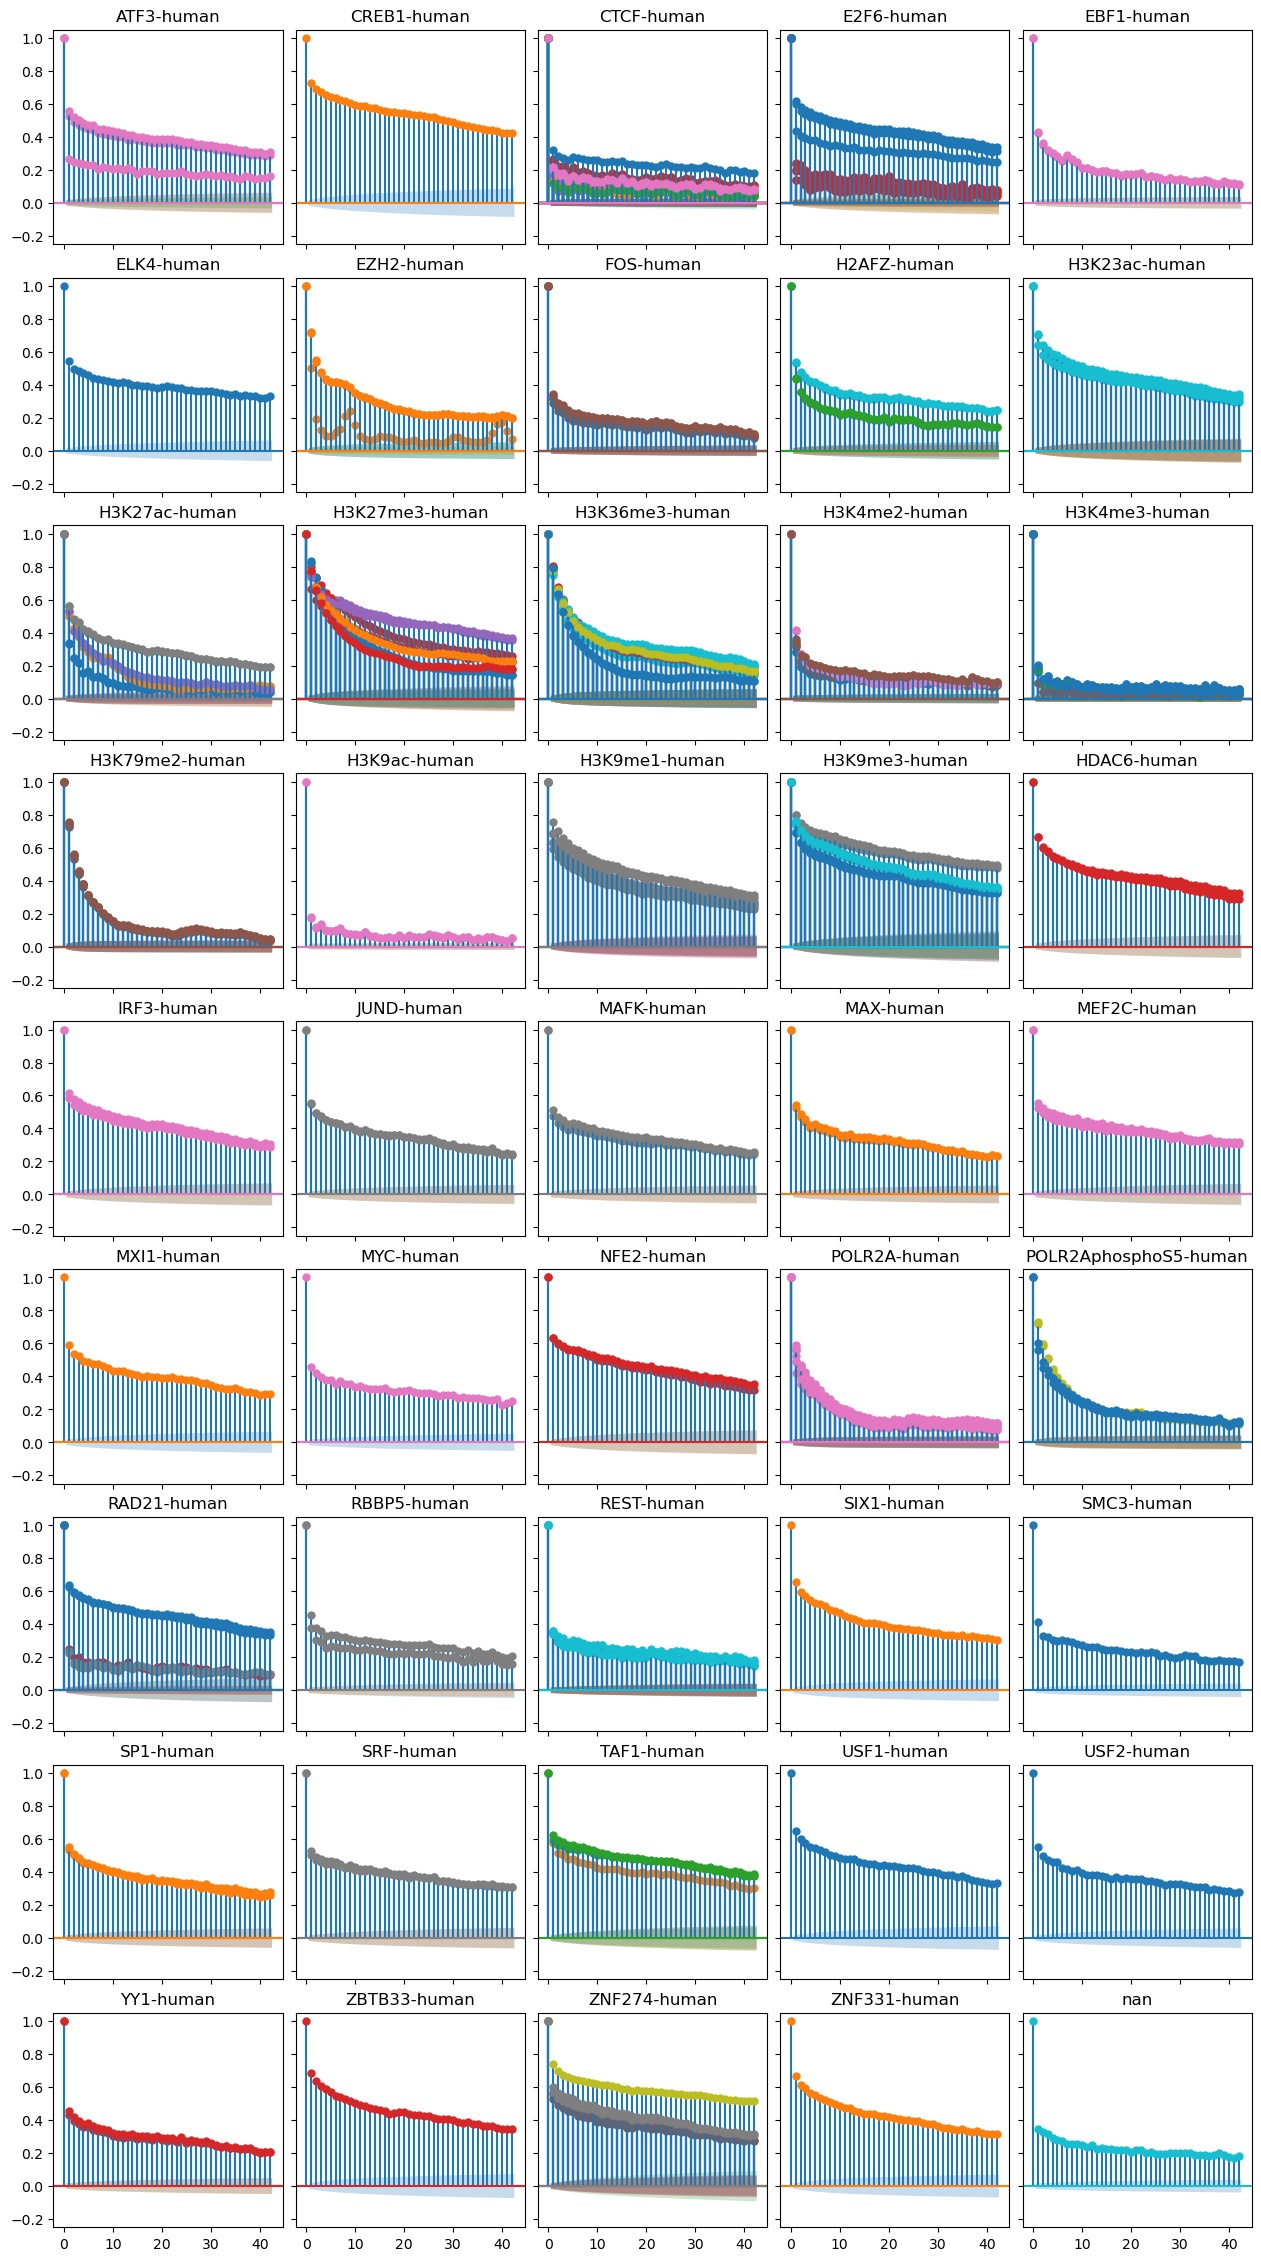

In [666]:
fig, axs = plt.subplots(9, 5, figsize = (12.5, 22.5), sharex = True, sharey = True, constrained_layout=True)
for i in range(200):
    data_i = df_signals.iloc[:, i]
    id_i = df_label.iloc[i, 8]
    row_i = id_i // 5
    col_i = id_i % 5
    color_i = df_label.iloc[i, 6]
    plot_acf(data_i, ax = axs[row_i, col_i], c = color_i)
for i in range(9):
    for j in range(5):
        axs[i, j].set(ybound = (-0.25, 1.05), title = list(le_expt_tar.classes_)[i * 5 + j])
plt.show()

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


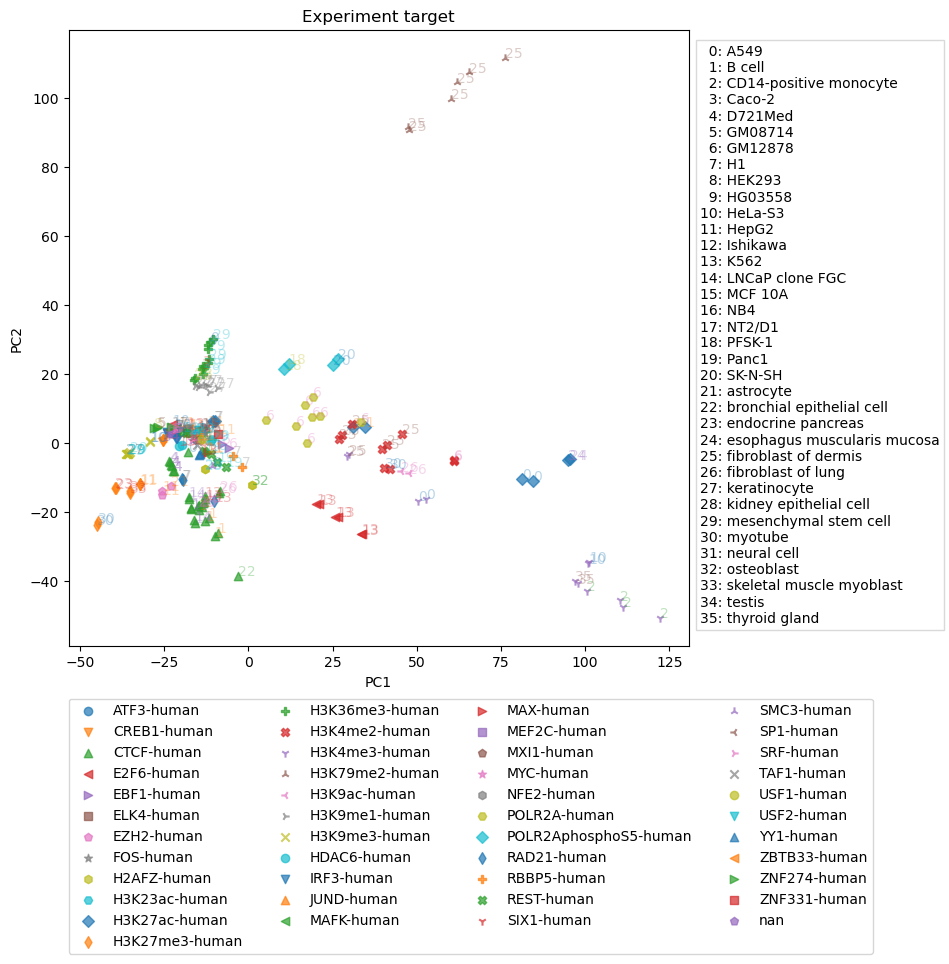

In [420]:
fig, ax = plt.subplots(figsize = (8, 8))

for i, lex in enumerate(le_expt_tar.classes_):
        X = df_label[df_label.expt_tar == lex].iloc[:,0]
        Y = df_label[df_label.expt_tar == lex].iloc[:,1]
        ax.scatter(X, Y, alpha = 0.7, label = lex, 
                       marker = markers[i % len(markers)], c = colors[i % len(colors)])

for i in range(df_label.shape[0]):
    ax.text(df_label.iloc[i, 0], df_label.iloc[i, 1], df_label.iloc[i, 5], 
                c = df_label.iloc[i, 6], alpha = 0.3)
    
ax.legend(loc = (0, -0.5), ncols = 4)
ax.set(xlabel = "PC1", ylabel = "PC2", title = "Experiment target")

ax.text(134, -52, text, bbox = dict(boxstyle = "square", ec = (0.85, 0.85, 0.85), fc = (1, 1, 1)))

plt.show()

<span style='color:Blue'> 
    Column "Audit ERROR" seems to be useful for outlier removal. The points with PC2 > 0.2 (shown above in blue circles) are probably outliers, as they are far away from most of the other points. Additionally, according to the information in the column "Audit ERROR", these points have "control extremely low read depth, extremely low read depth, missing control alignments," which represents the most severe errors of all the categories in the column.
</span>

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


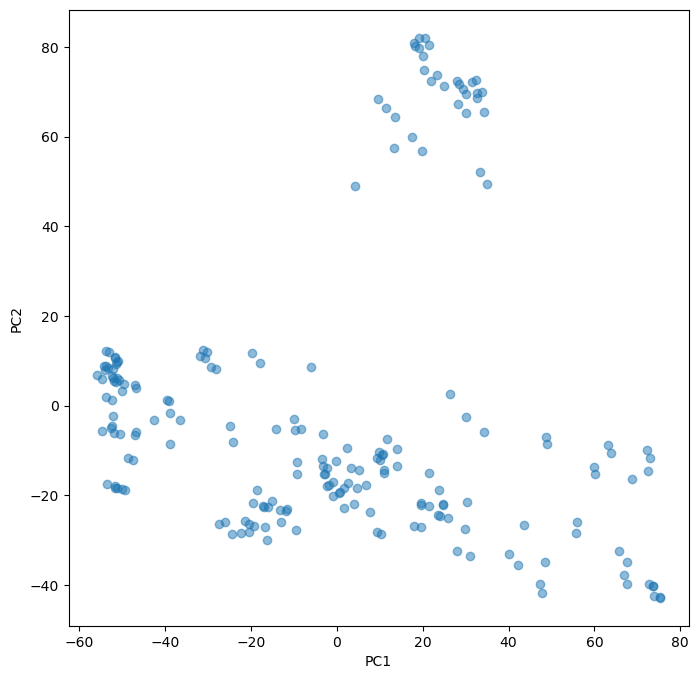

In [126]:
df_clean = df[(df["start"] < 40000000) | (df["start"] > 41500000)]
df_clean_signals = df_clean.iloc[:, 3:]

scaler = StandardScaler().fit(df_clean_signals)
df_scaled = scaler.transform(df_clean_signals)
df_scaled_t = df_scaled.T

pca = PCA(n_components = 2)
df_scaled_t_pca = pca.fit_transform(df_scaled_t)

fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(df_scaled_t_pca[:, 0], df_scaled_t_pca[:, 1], alpha = 0.5)
ax.set(xlabel = "PC1", ylabel = "PC2")
plt.show()

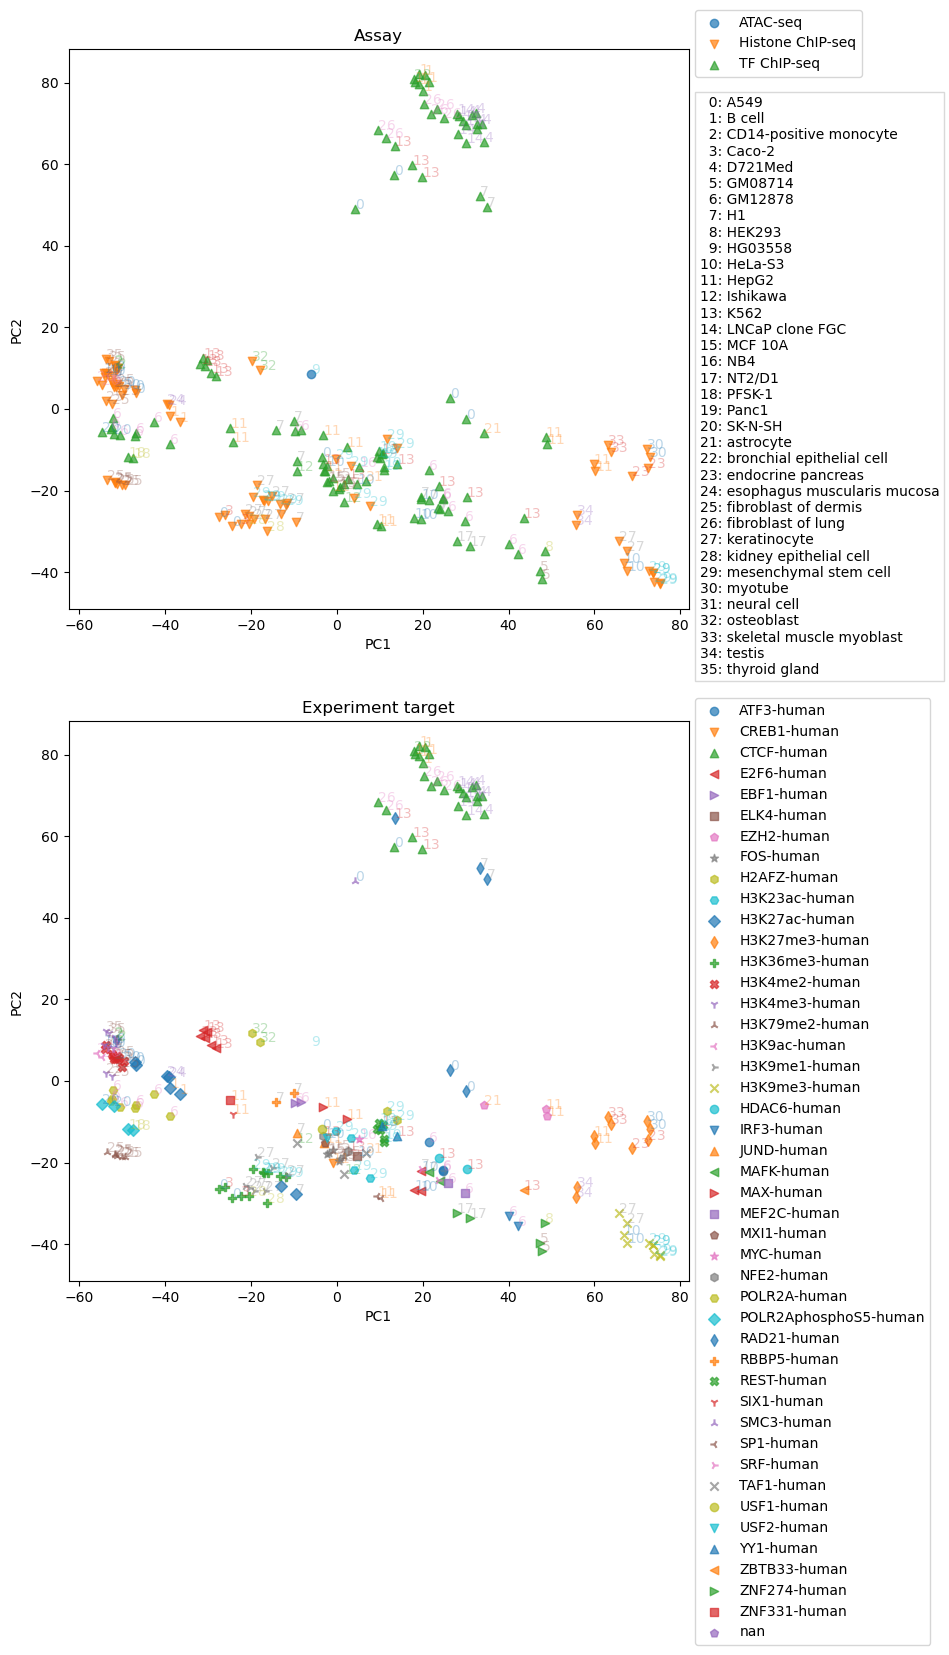

In [507]:
data_scaled = {'PC1': df_scaled_t_pca[:, 0], 'PC2': df_scaled_t_pca[:, 1], 
        "assay": labels_assay, "expt_tar": labels_expt_tar, "term": labels_term, 
        "term_index": term_index, "term_color": term_color}
df_label_scaled = pd.DataFrame(data = data_scaled)

df_label_scaled["assay_index"] = le_assay.transform(labels_assay)
df_label_scaled["expt_tar_index"] = le_expt_tar.transform(labels_expt_tar)


fig, axs = plt.subplots(2, figsize = (8, 16))


for i, la in enumerate(le_assay.classes_):
    X = df_label_scaled[df_label_scaled.assay == la].iloc[:,0]
    Y = df_label_scaled[df_label_scaled.assay == la].iloc[:,1]
    axs[0].scatter(X, Y, alpha = 0.7, label = la,
                   marker = markers[i % len(markers)], c = colors[i % len(colors)])

for i in range(df_label_scaled.shape[0]):
    axs[0].text(df_label_scaled.iloc[i, 0], df_label_scaled.iloc[i, 1], df_label_scaled.iloc[i, 5], 
                c = df_label_scaled.iloc[i, 6], alpha = 0.3)

    
axs[0].set(xlabel = "PC1", ylabel = "PC2", title = "Assay")
axs[0].legend(loc = (1.01, 0.95))

axs[0].text(84.5, -65, text, bbox = dict(boxstyle = "square", ec = (0.85, 0.85, 0.85), fc = (1, 1, 1)))



for i, lex in enumerate(le_expt_tar.classes_):
        X = df_label_scaled[df_label_scaled.expt_tar == lex].iloc[:,0]
        Y = df_label_scaled[df_label_scaled.expt_tar == lex].iloc[:,1]
        axs[1].scatter(X, Y, alpha = 0.7, label = lex, 
                       marker = markers[i % len(markers)], c = colors[i % len(colors)])

for i in range(df_label_scaled.shape[0]):
    axs[1].text(df_label_scaled.iloc[i, 0], df_label_scaled.iloc[i, 1], df_label_scaled.iloc[i, 5], 
                c = df_label_scaled.iloc[i, 6], alpha = 0.3)
    
axs[1].legend(loc = (1.01, -0.65))
axs[1].set(xlabel = "PC1", ylabel = "PC2", title = "Experiment target")

plt.show()


- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


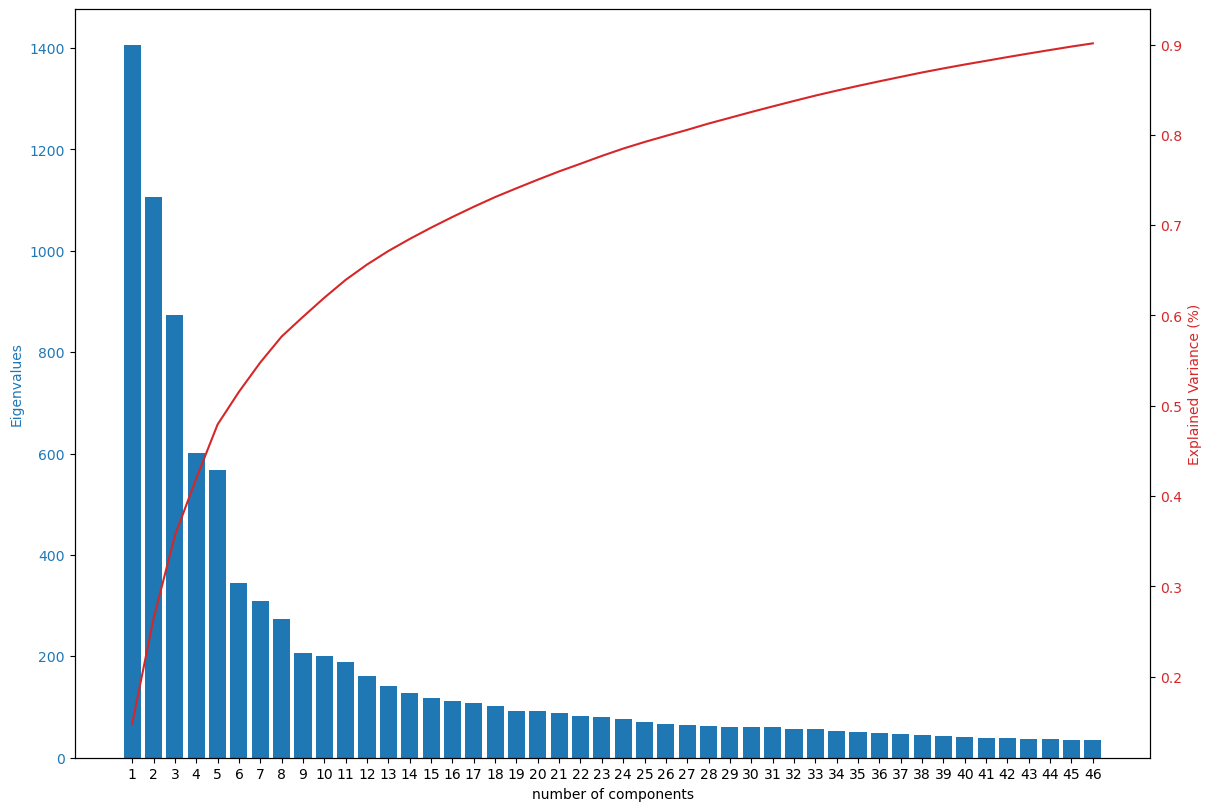

In [655]:
n_components = 1
pca = PCA(n_components)
pca.fit(df_scaled_t)
explained = [np.sum(pca.explained_variance_ratio_)]
while explained[-1] < 0.90:
    n_components += 1
    pca = PCA(n_components)
    pca.fit(df_scaled_t)
    explained.append(np.sum(pca.explained_variance_ratio_))

X = np.arange(1, n_components + 1) 
color = 'tab:blue'
fig, ax1 = plt.subplots(figsize = (12, 8), constrained_layout = True)
ax1.bar(X, pca.explained_variance_, color = color)
ax1.set(xlabel = "number of components", xticks = list(np.arange(1, n_components + 1)))
ax1.set_ylabel("Eigenvalues", color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(X, explained, color = color)
ax2.set_ylabel('Explained Variance (%)', color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.show()

<span style='color:Blue'> 
    46 PCs are needed to to explain 90% of the variance in the data.
</span>

- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


/Users/wangqifan/anaconda3/envs/qbio577/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


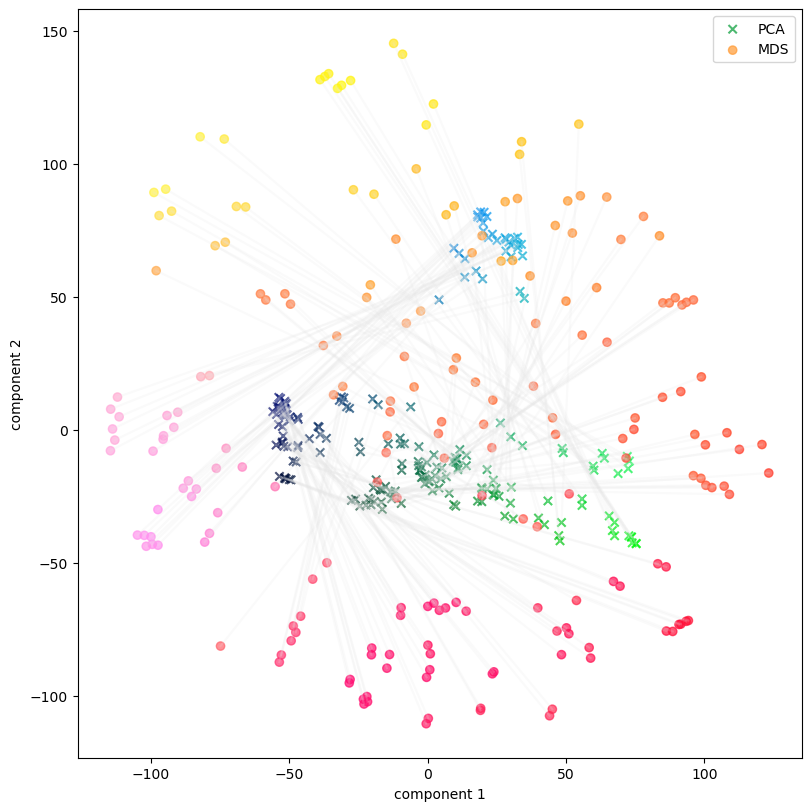

In [654]:
md_scaling = manifold.MDS(n_components = 2, random_state = 97, 
                          max_iter = 500000, n_init = 100)
data_scaling = md_scaling.fit_transform(df_scaled_t)

X = df_scaled_t_pca[:, 0]
Y = df_scaled_t_pca[:, 1]
G = (X + 60) / 140
B = (Y + 50) / 140
C1 = []
C2 = []
for i in range(X.shape[0]):
    C1.append((0, G[i], B[i]))
    C2.append((1, G[i], B[i]))
C1 = np.array(C1)
C2 = np.array(C2)

fig, ax = plt.subplots(figsize = (8, 8), constrained_layout = True)

for i in range(X.shape[0]):
    ax.plot([df_scaled_t_pca[i, 0], data_scaling[i, 0]], 
            [df_scaled_t_pca[i, 1], data_scaling[i, 1]], 
            alpha = 0.2, c = "0.9")
    

ax.scatter(df_scaled_t_pca[:, 0], df_scaled_t_pca[:, 1], alpha = 0.7, c = C1, marker = "x", label = "PCA")
ax.set(xlabel = "component 1", ylabel = "component 2")


ax.scatter(data_scaling[:, 0], data_scaling[:, 1], alpha = 0.7, c = C2, marker = "o", label = "MDS")
ax.legend()

plt.show()

<span style='color:Blue'> 
    The dimensionality reduction into two dimensions for PCA is different from that obtained using MDS. From the graph above, we see that the data points are more scattered across the plane consisting of the first two components for MDS than for PCA. The average distance between the positions of each data point on the plane consisting of the first two components for MDS and for PCA is also large. However, points that are close to each other in the plane consisting of the first two components for PCA also tend to be close to each other in the plane consisting of the first two components for MDS. For instance, the light green points in PCA correspond to the yellow points in MDS; the dark green points in PCA correspond to the orange points in MDS; the light blue points in PCA correspond to the pink points in MDS; and the dark blue points in PCA correspond to the red points in MDS.
</span>

- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


In [550]:
n_negative = int(df_clean_signals.where(df_clean_signals >= 0).isna().sum().sum())
print("The number negative entries in the data is: %i." % n_negative)

The number negative entries in the data is: 0.


<span style='color:Blue'> 
    Non-negative matrix factorization would be a useful method to use for this dataset. First of all, all the entries in the dataset are non-negative, which means that the prerequisite for using non-negative matrix factorization is satisfied. Furthermore, PCA can give rise to components containing negative values, which makes the interpretation of the PCA results impossible, whereas non-negative matrix factorization preserves the non-negativity of the data (neither W nor H contains negative entries), which makes the interpretation of the results easier.
</span>